In [36]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-c5fmeflj
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-c5fmeflj
  Resolved https://github.com/openai/CLIP.git to commit b46f5ac7587d2e1862f8b7b1573179d80dcdd620


In [37]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.11.0+cu102


In [38]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [39]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [40]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fbc20dac0d0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [41]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [42]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "gray_ellipse": "a gray ellipse",
    "yellow_ellipse": "a yellow ellipse",
    "white_rectangle": "a white rectangle"
}

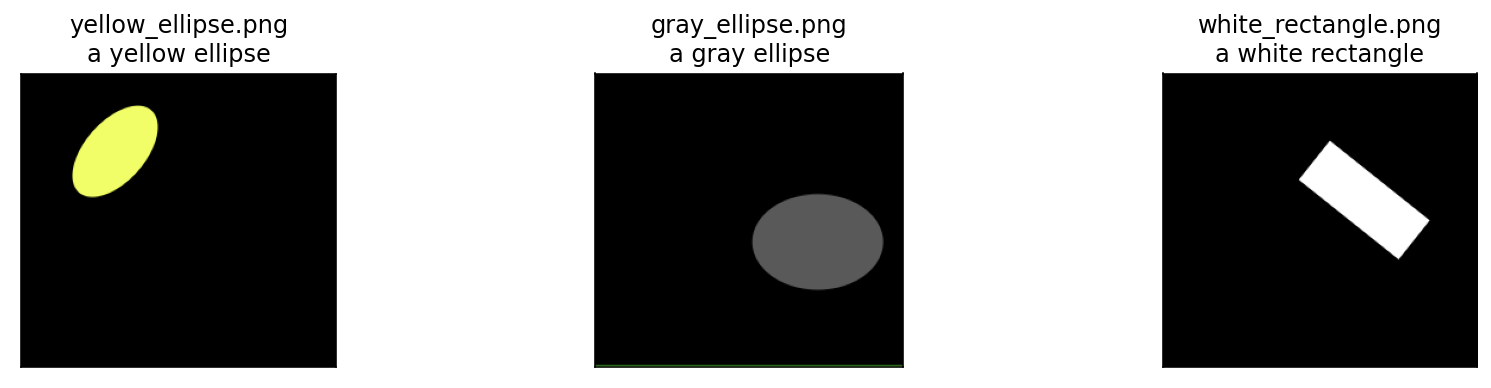

In [43]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))
filepath = os.path.join(os.getcwd(), "sw_temp")

for filename in [filename for filename in os.listdir(filepath) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]

    image = Image.open(os.path.join(filepath, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [44]:
print(images)

[tensor([[[-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         ...,
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923]],

        [[-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
         [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
         [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
         ...,
         [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
         [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
         [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521]],

        [[-1.4802, -1.4802, -1.4802,  ..., -1.4802, -1.4802, -1.4802],
         [-1.4802, -1.4802, -1.4802,  ..., -

In [45]:
print(texts)

['a yellow ellipse', 'a gray ellipse', 'a white rectangle']


In [46]:
["This is " + desc for desc in texts]

['This is a yellow ellipse',
 'This is a gray ellipse',
 'This is a white rectangle']

In [47]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [48]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [49]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

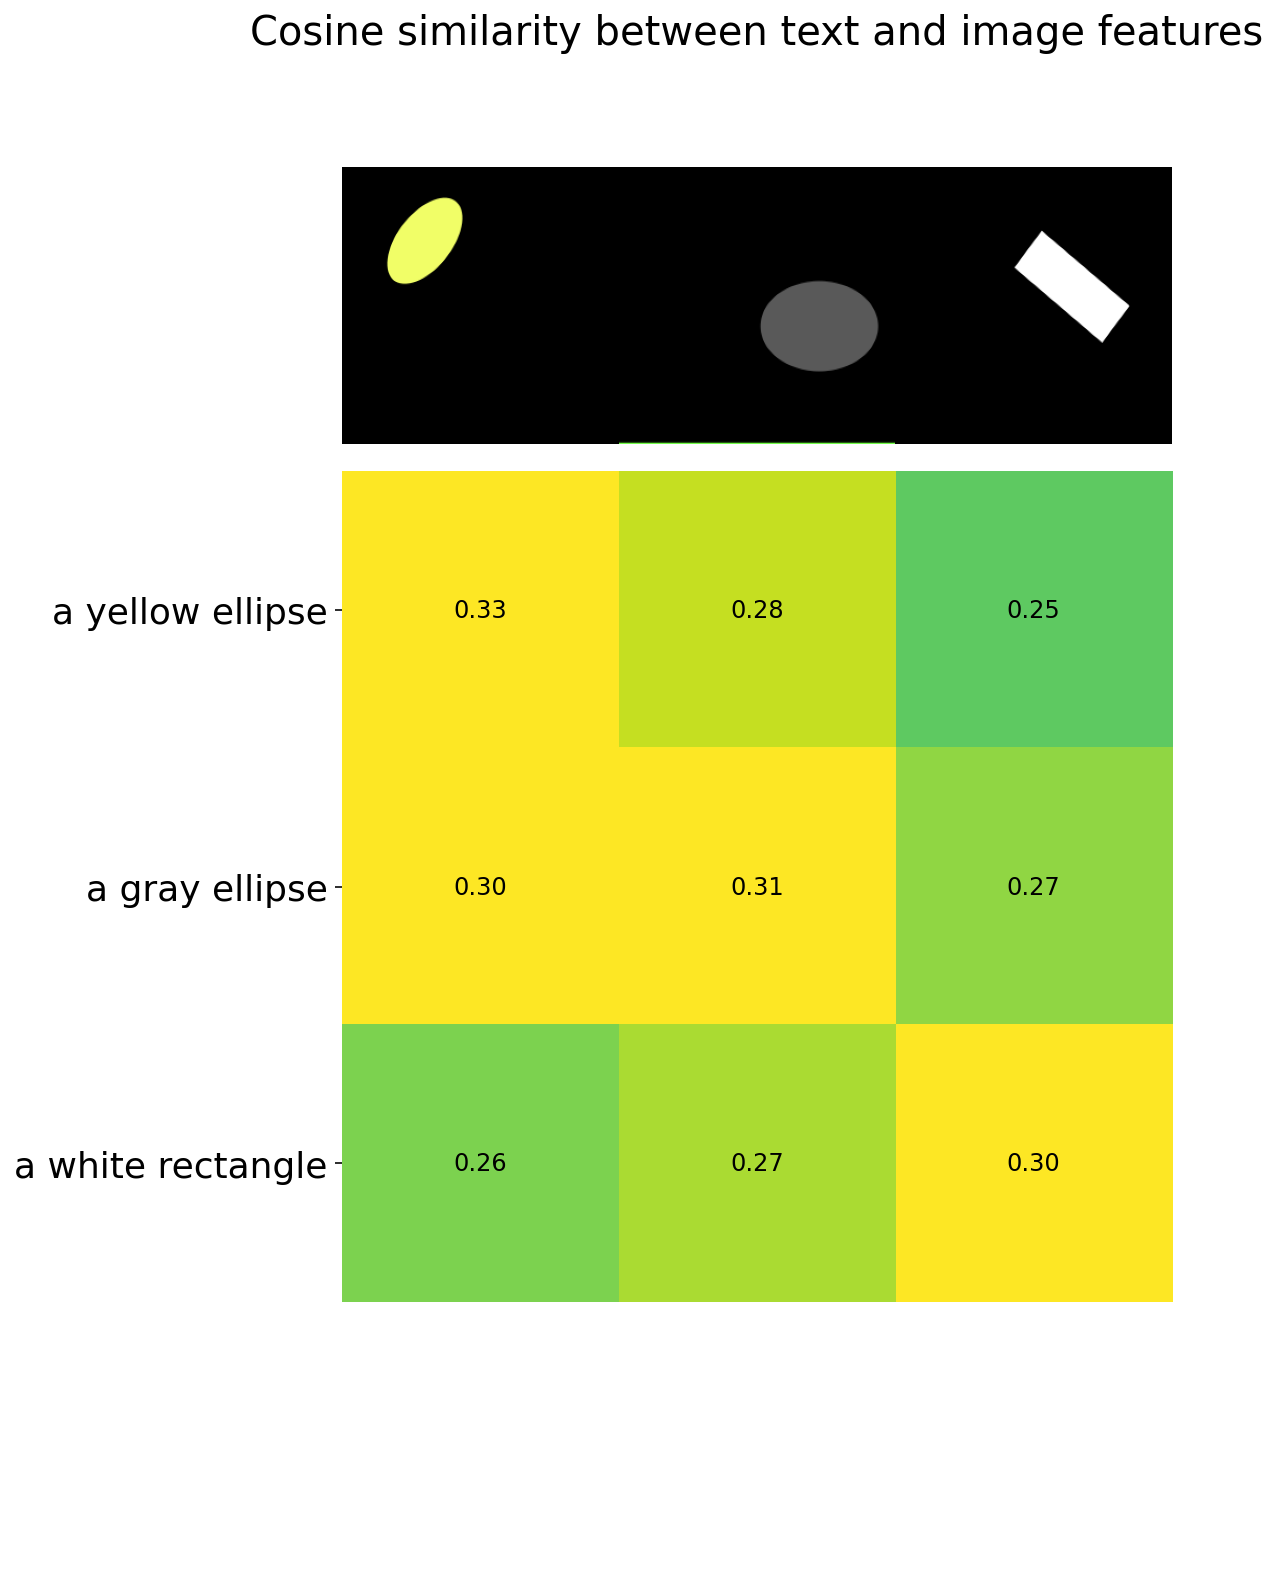

In [50]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

tensor([[0.5305, 0.2422, 0.2273]])
tensor([[1, 2, 0]])
tensor([[0.2273, 0.5305, 0.2422]], device='cuda:0')


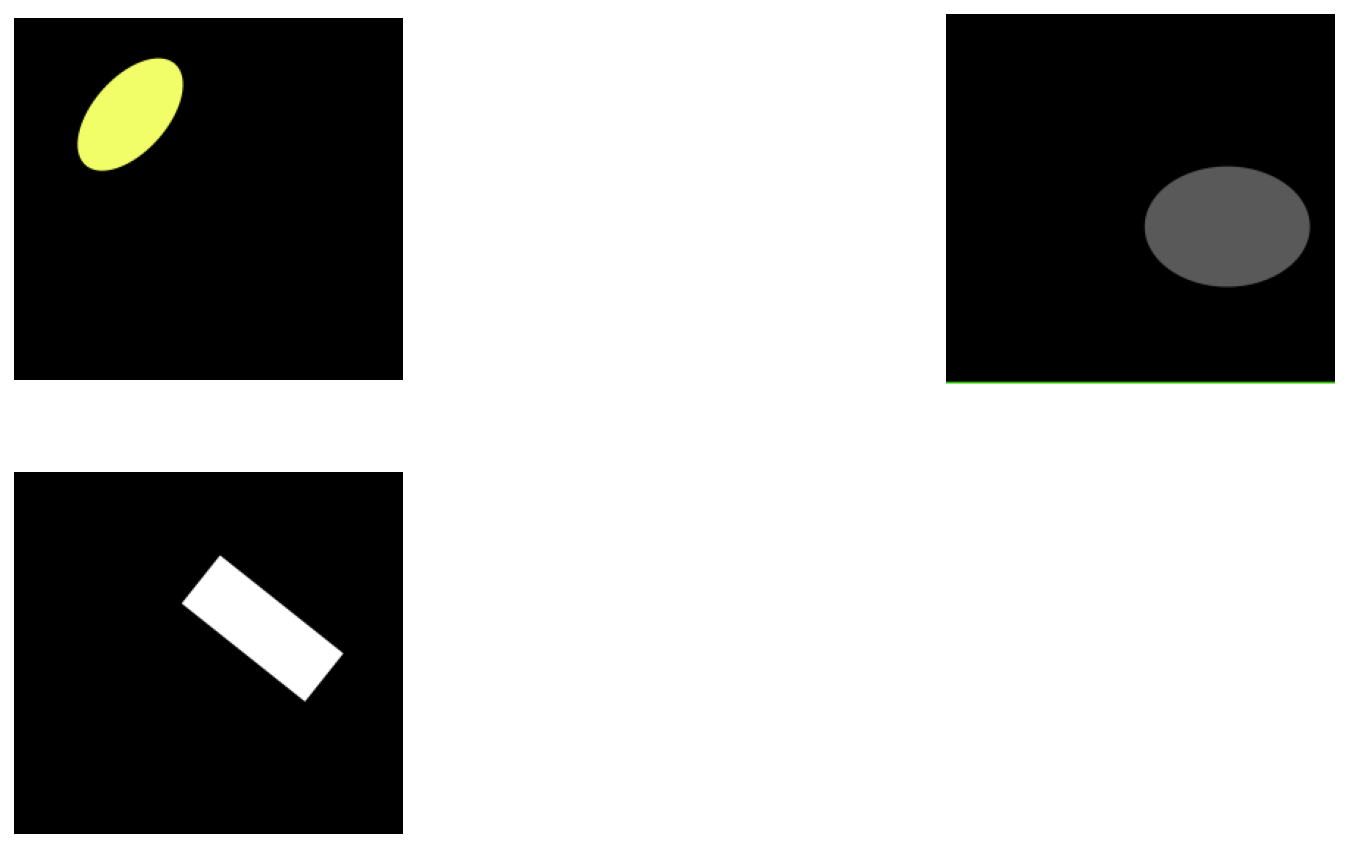

In [51]:
utterance = ["This is a gray shape"]
utterance_tokens = clip.tokenize(utterance).cuda()

with torch.no_grad():
    utterance_features = model.encode_text(utterance_tokens).float()
    utterance_features /= utterance_features.norm(dim=-1, keepdim=True)

image_probs = (100.0 * utterance_features @ image_features.T).softmax(dim=-1)
top_probs, top_labels = image_probs.cpu().topk(3, dim=-1)
print(top_probs)
print(top_labels)
print(image_probs)

plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
  plt.subplot(4, 4, 2 * i + 1)
  plt.imshow(image)
  plt.axis("off")